### Import packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.externals import joblib

%matplotlib inline

### Set-up

For this expercise, we will utilize two files (listed below) from the 'Brazilian E-Commerce Public Dataset' originally posted on [Kaggle]( https://www.kaggle.com/olistbr/brazilian-ecommerce).

In [3]:
# Full path of the 'orders' dataset
orders_file = 'https://www.dropbox.com/s/ej64qorm1uvmjlp/olist_orders_dataset.csv?dl=1'

# Full path of the 'customer' dataset
cust_file = 'https://www.dropbox.com/s/t082qlggu4wxiq5/olist_customers_dataset.csv?dl=1'

# File output location
out = r"C:\Users\visha\Downloads"

### Read data

In [4]:
def read_olist_data(file1, file2):
    
    # Read the orders data
    orders = pd.read_csv(file1)

    print (f'{len(orders):,d} read from the orders file.')

    # Drop unnecessary columns
    drop_vars = ['order_approved_at', 'order_delivered_carrier_date', 
                 'order_delivered_customer_date', 'order_estimated_delivery_date']

    orders = orders.drop(drop_vars, axis=1)

    # Date-time conversion
    orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

    # Let's convert the order purchase timestamps into dates
    orders['order_purchase_date'] = orders['order_purchase_timestamp'].dt.date

    # Extract month from the order date
    orders['order_month'] = orders['order_purchase_timestamp'].dt.month

    # Read the file that contains the unique customer identifier
    cust = pd.read_csv(file2)

    print (f'{len(cust):,d} read from the customer file.')

    # Let's keep only the following two columns: customer_id, customer_unique_id
    cust = cust[['customer_id', 'customer_unique_id']]

    # Merge orders and cust dataframes
    orders = pd.merge(orders, cust, on='customer_id', how='inner')
    
    print (f'{len(orders):,d} records in the output  file.')
    
    return orders

orders = read_olist_data(orders_file, cust_file)

99,441 read from the orders file.
99,441 read from the customer file.
99,441 records in the output  file.


In [5]:
# Let's keep only those columns that we need (for this exercise)

keep_cols = ['customer_unique_id', 'order_id', 'order_purchase_timestamp']

orders = orders[keep_cols].sort_values(['customer_unique_id', 'order_purchase_timestamp'])

orders.head()

,customer_unique_id,order_id,order_purchase_timestamp
52798,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27
73889,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27
26460,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03
98493,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41
41564,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42


## Binary Classification model

Let's build a model to predict whether a customer will make a purchase within the next month.

We will use *August 2018*, which is the most recent month, as the prediction window. In other words, we will use all available data prior to August 2018 to predict which customers will make a purchase in August 2018.

In [6]:
snapshot_date = date(2018, 7, 31)

### Attribute #1: Order recency

For creating model attributes (features) we will have to restrict our data to the timeframe prior to the prediction window

In [7]:
#from datetime import date

attr_raw = orders[orders['order_purchase_timestamp'].dt.date <= snapshot_date]

len(orders), len(attr_raw)

(99441, 92909)

In [8]:
attr_raw.order_purchase_timestamp.max()

Timestamp('2018-07-31 23:54:20')

In [9]:
# Another way to make such filter is by using a "mask"

mask = orders['order_purchase_timestamp'].dt.date <= snapshot_date

mask.head()

52798    True
73889    True
26460    True
98493    True
41564    True
Name: order_purchase_timestamp, dtype: bool

In [10]:
attr_raw = orders[mask]

len(attr_raw)

92909

To calculate recency (days since the most recent order), we will have to extract *the most recent date* for each customer.

In [11]:
# Get the max date for each customer

cust_recency = attr_raw.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()

cust_recency.head()

,customer_unique_id,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [12]:
# Count the number of days between the most recent order date and the snapshot date

delta = snapshot_date - cust_recency['order_purchase_timestamp'].dt.date

delta.head()

0    82 days
1    85 days
2   508 days
3   292 days
4   259 days
Name: order_purchase_timestamp, dtype: timedelta64[ns]

In [13]:
# Get the number of days (as an integer) from the calculated deltas 

cust_recency['order_recency'] = delta.dt.days

cust_recency.head()

,customer_unique_id,order_purchase_timestamp,order_recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,82
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,85
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,508
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,292
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,259


In [14]:
# Drop the date (we don't need it any more for this exercise)

cust_recency = cust_recency.drop('order_purchase_timestamp', axis=1)

In [15]:
# How many records (unique customers) do we have for this timeframe?

len(cust_recency)

89819

This is the number of customers who are included in the modeling dasetset for this specific time-frame.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


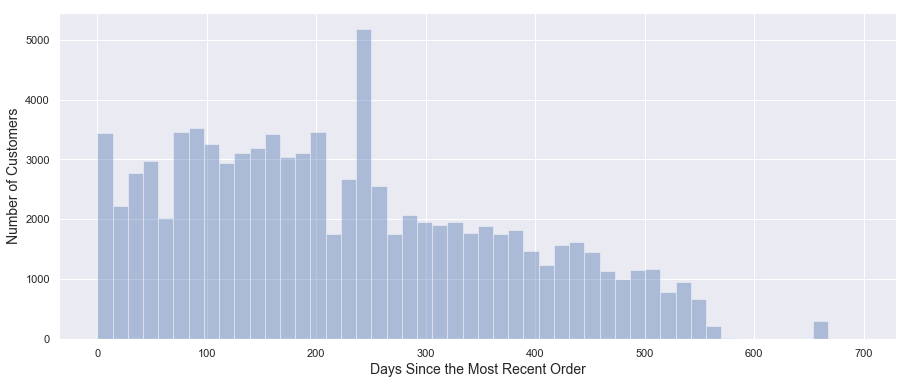

In [16]:
sns.set(style='darkgrid')

# Adjust the plot size
plt.figure().set_size_inches(15, 6)

# Histogram
sns.distplot(cust_recency['order_recency'], kde=False)

# Assign axis labels
plt.ylabel('Number of Customers', fontsize=14)
plt.xlabel('Days Since the Most Recent Order', fontsize=14);

In [17]:
cust_recency['order_recency'].max()

695

Let's take a look at the cumulative distribution of customers by recency.

In [18]:
recency_distr = cust_recency.groupby('order_recency').size().reset_index()
recency_distr = recency_distr.rename(columns={0: 'cust_count'})
recency_distr.head()

,order_recency,cust_count
0,0,322
1,1,288
2,2,186
3,3,175
4,4,188


In [19]:
cum_pctg = recency_distr['cust_count'].cumsum() / sum(recency_distr['cust_count'])

cum_pctg.head()

0    0.003585
1    0.006791
2    0.008862
3    0.010811
4    0.012904
Name: cust_count, dtype: float64

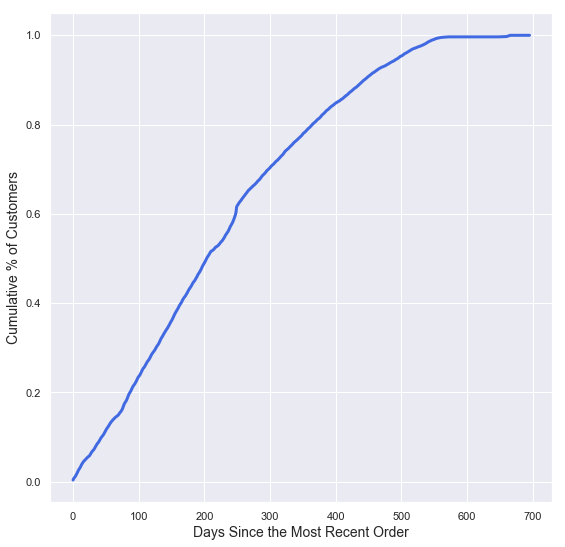

In [20]:
sns.set(style='darkgrid')

# Adjust the plot size
plt.figure().set_size_inches(9, 9)

# Histogram
sns.lineplot(x=recency_distr['order_recency'], y=cum_pctg, color='royalblue', lw=3)

# Assign axis labels
plt.ylabel('Cumulative % of Customers', fontsize=14)
plt.xlabel('Days Since the Most Recent Order', fontsize=14);

Additional eligibility criteria can be used to exclude customers (from the modeling dataset) who have not shopped in more than, e.g., one/two years. For this exercise, we will just proceed with all customers.

### Attribute #2: Number of orders per customer

In [21]:
# Count total records (i.e., orders) per customer

cust_orders = attr_raw.groupby('customer_unique_id').size().reset_index()

cust_orders.head()

,customer_unique_id,0
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [22]:
# Rename the new column

cust_orders = cust_orders.rename(columns={0: 'total_orders'})

### Combine both attributes into a single dataframe

In [23]:
# Combine (merge) `cust_recency` with `cust_orders` so that we have both attributes in one dataset

attr = pd.merge(cust_recency, cust_orders, on='customer_unique_id', how='inner')

len(attr)

89819

In [24]:
attr.head()

,customer_unique_id,order_recency,total_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,82,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,85,1
2,0000f46a3911fa3c0805444483337064,508,1
3,0000f6ccb0745a6a4b88665a16c9f078,292,1
4,0004aac84e0df4da2b147fca70cf8255,259,1


### Assign the Target variable (aka the Dependent variable)

For this exercise, we will assume that the objective of the model is to predict whether a customer will make *at least one purchase* in the future (i.e., within the target window of the model).

**Step 1:** Isolate all orders that were placed within the prediction window.

In [ ]:
# Select orders that were placed in August 2018

mask = (orders['order_purchase_timestamp'].dt.month == 8) & (orders['order_purchase_timestamp'].dt.year == 2018)

target_events_raw = orders[mask]

len(target_events_raw)

In [ ]:
# Confirm the min and max dates are within the month of August 2018

print (target_events_raw['order_purchase_timestamp'].min(), target_events_raw['order_purchase_timestamp'].max())

**Step 2:** Summarize data to get one record per customer.

In [ ]:
# Count the number of orders (we will convert this into a binary flag later)

target_events = target_events_raw.groupby('customer_unique_id').size().reset_index()

target_events.head()

In [ ]:
len(target_events)

This is the number of customers -- out of the eligible population of 89,819 -- who made at least one purchase during the prediction window.

**Step 3:** Merge this dataframe with the `attr` dataframe to create the modeling dataset.

In [ ]:
# Merge the new dataframe (created above) with the dataframe that contains customer attributes

df = pd.merge(attr, target_events, how='left', on='customer_unique_id')

df.head()

In [ ]:
# Rename the target column

df = df.rename(columns={0: 'purch'})

df.shape

In [ ]:
df.purch.value_counts()

We need to convert this variable into a binary flag.

**Step 4:** Set the target variable to 1 if at least one purchase was made, 0 otherwise.

In [ ]:
# Create the binary target flag

df['purch'] = [1 if x > 0 else 0 for x in df['purch']]

df.head()

In [ ]:
# Check the distribution of the target flag

df.purch.value_counts()

In [ ]:
# % distribution of the target flag

df.purch.value_counts() / len(df)

In [ ]:
# Check the correlations

df[['order_recency', 'total_orders', 'purch']].corr()

### Model building

In [ ]:
# Set-up

preds = ['order_recency', 'total_orders']

X = df[preds]
y = df['purch']

Tri-fold partitioning is recommended as long as there's sufficient sample size avaiable. In this example, since the number of target events is very small, we will perform a two-fold paritioning of the modeling sample.

Note that we could increase the size of the prediction window to capture more purchase events. However, for this exercise we will continue with the current prediction window (of one month).

#### Two-fold partition

In [ ]:
# Split the dataframe into train(50%) and test(50%)

#from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=314)

len(X_train), len(X_test)

In [ ]:
# Target distribution in the trainig sample

y_train.value_counts()

In [ ]:
# Target distribution in the test sample

y_test.value_counts()

In [ ]:
#from sklearn.linear_model import LogisticRegression

# Define the model object
clf = LogisticRegression(solver='liblinear', random_state=314)

# Train (fit) the model using the training sample
clf.fit(X_train, y_train)

# Make predictions on the test sample
preds_test = clf.predict(X_test)

### Model accuracy

In [ ]:
#from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds_test)

Why does the model appear to be very strong in spite of only two predictors that didn't look correlated with the target?

In [ ]:
# Check model's predictions against actual value of the target event

pd.crosstab(y_test, preds_test)


The model is predicting 0 (no purchase) for all customers!

Area under the ROC curve (AUC)

In [ ]:
# Calculate the probabilities on the test sample

scores_test = clf.predict_proba(X_test)[:, 1]


# Calcualte AUC

roc_auc_score(y_test, scores_test)

## Export results

#### 1. Scored dataset (with all model attributes)

In [ ]:
scores_all = clf.predict_proba(df[preds])[:, 1]

df['prob_to_purchase'] = scores_all

df.head()

In [ ]:
csv_file_zipped = out + '\olist_purch_model_scores.csv.gz'

df.to_csv(csv_file_zipped, compression='gzip')

#### 2. Export the model

In [ ]:
#from sklearn.externals import joblib

model_pkl_file = out + '\olist_purch_model.joblib'

joblib.dump(clf, model_pkl_file)

##### Load the model

In [ ]:
clf_loaded = joblib.load(model_pkl_file)

clf_loaded

In [ ]:
# Use the model to score a "new" data frame

clf_loaded.predict_proba(X_test)